Spawning PlanarRigidBodyVisualizer for tree with 0 actuators


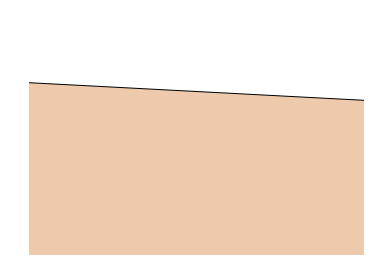

In [9]:
import math
import numpy as np

from pydrake.all import (Box,
                         DiagramBuilder,
                         FindResourceOrThrow,
                         FloatingBaseType,
                         Isometry3,
                         RigidBodyTree,
                         SignalLogger,
                         Simulator,
                         VisualElement)
from pydrake.examples.compass_gait import (CompassGait, CompassGaitParams)
from underactuated import (PlanarRigidBodyVisualizer)

from IPython.display import HTML


tree = RigidBodyTree(FindResourceOrThrow(
                        "drake/examples/compass_gait/CompassGait.urdf"),
                     FloatingBaseType.kRollPitchYaw)
params = CompassGaitParams()

R = np.identity(3)
R[0, 0] = math.cos(params.slope())
R[0, 2] = math.sin(params.slope())
R[2, 0] = -math.sin(params.slope())
R[2, 2] = math.cos(params.slope())
X = Isometry3(rotation=R, translation=[0, 0, -5.])
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 1., 10.]), X, color))
tree.compile()


builder = DiagramBuilder()
compass_gait = builder.AddSystem(CompassGait())


logger = builder.AddSystem(SignalLogger(compass_gait.get_output_port(1).size()))
logger._DeclarePeriodicPublish(1. / 30., 0.0)

builder.Connect(compass_gait.get_output_port(1), logger.get_input_port(0))
#builder.ExportInput(robot.get_input_port(0)) #this allows the outside world to see push inputs in (or whatever)


#builder.Connect(compass_gait.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.set_publish_every_time_step(True)
simulator.get_mutable_context().set_accuracy(1e-4)

state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
state.SetFromVector([0., 0., 0.4, -2.])

simulator.StepTo(5)


prbv = PlanarRigidBodyVisualizer(tree, xlim=[-5, 5], ylim=[-5, 2.5])
ani = prbv.animate(logger, repeat=True)
#plt.close(prbv.fig)
HTML(ani.to_html5_video())
    